---
# Introduction
---

DLinear is just a fully connected with the Autoformer's **DecompositionLayer**. The DLinear model first decomposes a raw data input into a trend component by a moving average kernel and a remainder (seasonal) component. Then, two one-layer linear layers are applied to each component, and we sum up the two features to get the final prediction.

### Decomposition layer 
The decomposition scheme used in DLinear is a combination of the one used in Autoformer and FEDformer.


<img width="800" src="https://www.researchgate.net/publication/360888216/figure/fig2/AS:1160187520004104@1653621668476/Illustration-of-the-Decomposition-Linear-Model.png" alt="Informer Architecture" />


---
## Inputs and Outputs
---
##### **Input sequence:**
The input of a DLinear model is a raw data input, which is a sequence of observations recorded at regular intervals over time. the input sequence directly feed to the decomposition linear model.


- The length of the input sequence is defined by the seq_len hyperparameter.

##### **Output sequence:**
The output of a DLinear model is the final prediction, which is obtained by summing up the two features extracted from the trend and seasonal components of the input data. The two features are obtained by applying two one-layer linear layers to each component.

- The length of the output sequence is defined by the pred_len hyperparameter.


---
## Methodology
---
This notebook provide a step-by-step guide for replicating the **Dlinear** model and training it on the ETDataset (ETTh1, ETTh2, ETTm1, and ETTm2), ensuring accurate reproduction of the models by comparing the notebook results with the official paper results. The workflow from the beginning to forcasting is as follows:

### 1. Data Decomposition
The raw data input is decomposed into a trend component and a remainder (seasonal) component using a moving average kernel. This step is performed to handle time series data with a clear trend.
### 2. Linear Layers
Two one-layer linear layers are applied to each component to extract two features.
### 3. Feature Summation
The two features extracted from the trend and seasonal components are summed up to get the final prediction.

---
## Hyperparameters
---

**Some of the hyperparameters control the input and output of the mode**

1. `args.features`: The forecasting task, options: [M, S, MS]; M: multivariate predict multivariate, 2: univariate predict univariate, MS: multivariate predict univariate
3. `args.target`: The target feature in S or MS task
4. `args.enc_in`: The size of the encoder input
5. `args.dec_in`: The size of the decoder input
6. `args.c_out`: The output size of the decoder
7. `args.batch_size`: The batch size used during training and inference

-----------

**hyperparameters  for controlling the sequence lengths:**

1. `args.seq_len`: The length of the input sequence of the DLinear encoder.
2. `args.pred_len`: The length of the output sequence to be predicted by the model.
3. `args.label_len`: The length of the start token series used as input to the DLinear decoder.

-----------

**hyperparameters for controlling the architecture and training process:**

1. `args.d_model`: The dimension of the model.
2. `args.n_heads`: The number of attention heads in the model.
3. `args.e_layers`: The number of layers in the encoder.
4. `args.d_layers`: The number of layers in the decoder.
5. `args.d_ff`: The dimension of the feedforward layer in the model.
6. `args.dropout`: The dropout rate.
7. `args.attn`: The type of attention used in the encoder, options: [prob, full].
8. `args.embed`: The type of time features encoding, options: [timeF, fixed, learned].
9. `args.activation`: The activation function used in the model.
10. `args.distil`: Whether to use distilling in the encoder.
11. `args.loss`: The loss function used during training.
12. `args.learning_rate`: The learning rate used during training.
13. `args.train_epochs`: The number of epochs to train the model.
14. `args.patience`: The number of epochs to wait before early stopping if the validation loss does not improve.
15. `args.use_amp`: Whether to use automatic mixed precision training.

**hyperparameters with their descriptions for controlling other aspects of the DLinear model:**

1. `args.output_attention`: Whether to output attention in the encoder.
2. `args.checkpoints`: The location of model checkpoints.
3. `args.num_workers`: The number of workers used for data loading.
4. `args.gpu`: The GPU index to use for training and inference.
5. `args.devices`: The indices of the GPUs to use for multi-GPU training.

Note that these hyperparameters control other aspects of the DLinear model, such as debugging, data loading, and GPU settings, and can be adjusted based on the specific requirements of the experiment.

---
# Setup
---

**Add project_files to system path**

In [1]:
import sys
if not 'Time-Series-Forcasting-Group3' in sys.path:
    sys.path += ['Time-Series-Forcasting-Group3']
    
sys.path

['/home/jovyan/new_mohamed/Final-Time-Series-Forecasting',
 '/opt/conda/lib/python39.zip',
 '/opt/conda/lib/python3.9',
 '/opt/conda/lib/python3.9/lib-dynload',
 '',
 '/opt/conda/lib/python3.9/site-packages',
 'Time-Series-Forcasting-Group3']

**Important library**

In [7]:
import torch
# import matplotlib.pyplot as plt
# import seaborn as sns
import os
from exp.exp_DLinear import Exp_Main #, Dataset_Pred

In [11]:
class dotdict(dict):
    """dot.notation access to dictionary attributes"""
    __getattr__ = dict.get
    __setattr__ = dict.__setitem__
    __delattr__ = dict.__delitem__
    
"""
    **dotdict function**
    This function is used to convert a dictionary into
    an object whose keys can be accessed as attributes
"""

args = dotdict()

**GPU Device Hyperparameters**

In [12]:
######################### Device Hyperparameters  ##########################
args.use_multi_gpu = False
args.num_workers = 0
args.use_gpu = torch.cuda.is_available() 
args.gpu = 0                           # The index of the GPU to use.

**Dataset Hyperparameters**

In [13]:
######################### Dataset Hyperparameters  ##########################
args.data = 'ETTh1'            # dataset name
args.root_path = './Datasets/' # root path of data file
args.data_path = 'ETTh1.csv'   # data file
args.features = 'M'            # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
args.target = 'OT'             # target feature in S or MS task
args.freq = 'h'                # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
args.embed = 'timeF'           # time features (date) encoding, options:[timeF, fixed, learned]
args.padding = 0               # the amount of padding to add to the input sequence of the Informer model

**Experiment Hyperparameters**



In [14]:
######################### Experiment Hyperparameters  ##########################

# args.output_attention = False # whether to output attention in ecoder
args.train_only = True
args.train_epochs = 10        # The number of epochs to train for.
args.batch_size = 16          # The batch size of training input data.
args.learning_rate = 0.005    # learning rate starts from 1e−4, decaying two times smaller every epoch.
args.lradj = 'type1'          # learning rate decayed two times smaller every epoch.
args.loss = 'mse'             # evaluating criteria
args.patience = 3             # The number of epochs to wait before early stopping.
args.des = 'Exp'              # The description of the experiment.
args.itr  = 1

args.model = 'DLinear' 
args.checkpoints = './Checkpoints/DLinear_checkpoints' # location of model checkpoints

**Modeling Hyperparameters**

In [15]:
args.enc_in = 7 
args.label_len = 48
args.seq_len = 336              # input sequence length of DLinear encoder
args.pred_len = 96              # prediction sequence length

---
# Working on ETTh1 Dataset
---

## Trail 1: DLinear, Dataset:ETTh1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [4]:
# """
#     **dotdict function**
#     This function is used to convert a dictionary into
#     an object whose keys can be accessed as attributes
# """

# args = dotdict()

# args.model = 'DLinear' 
# #args.use_multi_gpu = False
# #args.use_gpu = True if torch.cuda.is_available() else False
# args.learning_rate = 0.005
# args.pred_len = 96 # prediction sequence length
# args.label_len = 48 # start token length of DLinear decoder
# args.use_amp = False # whether to use automatic mixed precision training
# args.output_attention = False # whether to output attention in ecoder
# args.features = 'M' # forecasting task, options:[M, S, MS]; M:multivariate predict multivariate, S:univariate predict univariate, MS:multivariate predict univariate
# #args.train_only=True
# args.checkpoints = './Checkpoints/DLinear_checkpoints' # location of model checkpoints
# args.patience = 3
# args.train_epochs = 10

# #args.data = 'ETTh1'  # data
# #args.root_path = './Datasets/' # root path of data file
# #args.data_path = 'ETTh1.csv' # data file
# args.target = 'OT' # target feature in S or MS task
# #args.freq = 'h' # freq for time features encoding, options:[s:secondly, t:minutely, h:hourly, d:daily, b:business days, w:weekly, m:monthly], you can also use more detailed freq like 15min or 3h
# args.seq_len = 336 # input sequence length of DLinear encoder

# # DLinear decoder input: concat[start token series(label_len), zero padding series(pred_len)]
# args.enc_in = 7 # encoder input size
# args.dec_in = 7 # decoder input size
# args.c_out = 7 # output size
# #args.factor = 5 # probsparse attn factor
# args.d_model = 512 # dimension of model
# # args.n_heads = 8 # num of heads
# # args.e_layers = 2 # num of encoder layers
# # args.d_layers = 1 # num of decoder layers
# # args.d_ff = 2048 # dimension of fcn in model
# # args.dropout = 0.05 # dropout
# # args.attn = 'prob' # attention used in encoder, options:[prob, full]
# args.embed = 'timeF' # time features encoding, options:[timeF, fixed, learned]
# # args.activation = 'gelu' # activation
# args.distil = True # whether to use distilling in encoder
# #args.mix = True
# #args.padding = 0
# args.freq = 'h'
# args.batch_size = 32 
# args.loss = 'mse'
# #args.lradj = 'type1'
# # args.num_workers = 0
# args.des = 'exp'
# args.gpu = 0
# # args.devices = '0,1,2,3'

In [6]:
setting=f'{args.model}_train_on_{args.data}_{args.pred_len}_test'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh1_96_test:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [7]:
# set experiments
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.3413215 (MSE)
    Speed: 0.2610 sec/iter 
    Left time: 642.3281 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.4033173 (MSE)
    Speed: 0.2411 sec/iter 
    Left time: 569.2357 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 256 	 Train Loss: 0.4021522
     Validation loss decreased (inf --> 0.402152).  Saving model ...
Updating learning rate to 0.005
Epoch: 2, Iters: 100
----------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=96, bias=True)
)

### Testing

In [8]:
exp.test(setting)
torch.cuda.empty_cache()

test 2785
mae:0.3915349543094635, mse:0.37019482254981995, rmse:0.6084363460540771, mape:8.988804817199707, mspe:35007.46875


---
## Trail 2: DLinear, Dataset:ETTh1 , Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary

In [9]:
args.pred_len = 192 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh1_192:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [10]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8113
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.4420341 (MSE)
    Speed: 0.3530 sec/iter 
    Left time: 858.2599 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.4182466 (MSE)
    Speed: 0.3608 sec/iter 
    Left time: 841.0804 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 253 	 Train Loss: 0.4583256
     Validation loss decreased (inf --> 0.458326).  Saving model ...
Updating learning rate to 0.005
Epoch: 2, Iters: 100
----------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=192, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=192, bias=True)
)

### Testing

In [11]:
exp.test(setting)
torch.cuda.empty_cache()

test 2689
mae:0.4138428270816803, mse:0.40499380230903625, rmse:0.6363912224769592, mape:8.583948135375977, mspe:30955.697265625


---
## Trail 3: DLinear, Dataset:ETTh1,  Metric: 336

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [12]:
args.pred_len = 336 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh1_336:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [13]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7969
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.4675936 (MSE)
    Speed: 0.4539 sec/iter 
    Left time: 1085.3543 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.5768208 (MSE)
    Speed: 0.4511 sec/iter 
    Left time: 1033.5166 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 249 	 Train Loss: 0.5083509
     Validation loss decreased (inf --> 0.508351).  Saving model ...
Updating learning rate to 0.005
Epoch: 2, Iters: 100
--------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=336, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=336, bias=True)
)

### Testing

In [14]:
exp.test(setting)
torch.cuda.empty_cache()

test 2545
mae:0.434622198343277, mse:0.4337225556373596, rmse:0.6585761308670044, mape:8.49459171295166, mspe:29168.8984375


---
## Trail 4: DLinear, Dataset:ETTh1,  Metric: 720

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [16]:
args.pred_len = 720 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh1_720:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTh1', 'root_path': './Datasets/', 'data_path': 'ETTh1.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [17]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7585
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.5775622 (MSE)
    Speed: 0.4640 sec/iter 
    Left time: 1053.8281 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.5712538 (MSE)
    Speed: 0.4800 sec/iter 
    Left time: 1042.0119 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 237 	 Train Loss: 0.5915988
     Validation loss decreased (inf --> 0.591599).  Saving model ...
Updating learning rate to 0.005
Epoch: 2, Iters: 100
--------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=720, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=720, bias=True)
)

### Testing

In [18]:
exp.test(setting)
torch.cuda.empty_cache()

test 2161
mae:0.4867483675479889, mse:0.470274418592453, rmse:0.6857655644416809, mape:9.444793701171875, mspe:33059.78125


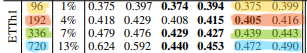

In [8]:
from IPython.display import Image
Image(filename=r"./Images/ETT1.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 |  0.37019482254981995| 0.3915349543094635  |
| 192 |  0.40499380230903625 | 0.4138428270816803 |
| 336 | 0.4337225556373596 | 0.434622198343277  |
| 720 | 0.470274418592453| 0.4867483675479889 |


---
# Working on ETTh2 Dataset
---

## Trail 1: DLinear, Dataset:ETTh2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [19]:
args.data_path = 'ETTh2.csv' # data file
args.data = 'ETTh2'  # data
args.pred_len = 96 # prediction sequence length

setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh2_96:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [20]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8209
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.5716219 (MSE)
    Speed: 0.2511 sec/iter 
    Left time: 617.9555 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.4432977 (MSE)
    Speed: 0.2399 sec/iter 
    Left time: 566.4675 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 256 	 Train Loss: 0.4678324
     Validation loss decreased (inf --> 0.467832).  Saving model ...
Updating learning rate to 0.005
Epoch: 2, Iters: 100
----------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=96, bias=True)
)

### Testing

In [21]:
exp.test(setting)
torch.cuda.empty_cache()

test 2785
mae:0.3672036826610565, mse:0.303977906703949, rmse:0.5513418912887573, mape:1.2718249559402466, mspe:288.70526123046875


---
## Trail 2: DLinear,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary

In [22]:
args.pred_len = 192 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh2_192:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [23]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 8113
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.2965879 (MSE)
    Speed: 0.2889 sec/iter 
    Left time: 702.3173 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.5459639 (MSE)
    Speed: 0.2951 sec/iter 
    Left time: 687.7701 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 253 	 Train Loss: 0.5720296
     Validation loss decreased (inf --> 0.572030).  Saving model ...
Updating learning rate to 0.005
Epoch: 2, Iters: 100
----------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=192, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=192, bias=True)
)

### Testing

In [24]:
exp.test(setting)
torch.cuda.empty_cache()

test 2689
mae:0.4267962872982025, mse:0.3962155878543854, rmse:0.6294565796852112, mape:1.3312541246414185, mspe:256.4117431640625


---
## Trail 3: DLinear, Dataset:ETTh2,  Metric: 336

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [25]:
args.pred_len = 336 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh2_336:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [26]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7969
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.7069765 (MSE)
    Speed: 0.2880 sec/iter 
    Left time: 688.5327 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.8455408 (MSE)
    Speed: 0.3550 sec/iter 
    Left time: 813.1995 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 249 	 Train Loss: 0.6509141
     Validation loss decreased (inf --> 0.650914).  Saving model ...
Updating learning rate to 0.005
Epoch: 2, Iters: 100
----------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=336, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=336, bias=True)
)

### Testing

In [27]:
exp.test(setting)
torch.cuda.empty_cache()

test 2545
mae:0.4841303825378418, mse:0.4873389005661011, rmse:0.6980966329574585, mape:1.4342966079711914, mspe:275.1256408691406


---
## Trail 4: DLinear, Dataset:ETTh2,  Metric: 720

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [28]:
args.pred_len = 720 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTh2_720:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTh2', 'root_path': './Datasets/', 'data_path': 'ETTh2.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [29]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 7585
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.7410195 (MSE)
    Speed: 0.3389 sec/iter 
    Left time: 769.6916 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.7023859 (MSE)
    Speed: 0.3480 sec/iter 
    Left time: 755.5732 sec
--------------------------------------------------------------------------------
                                   Epoch 1 Summery                          
--------------------------------------------------------------------------------
     Cost time: 1
     Steps: 237 	 Train Loss: 0.7815685
     Validation loss decreased (inf --> 0.781569).  Saving model ...
Updating learning rate to 0.005
Epoch: 2, Iters: 100
----------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=720, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=720, bias=True)
)

### Testing

In [30]:
exp.test(setting)
torch.cuda.empty_cache()

test 2161
mae:0.6122018098831177, mse:0.7422817349433899, rmse:0.8615577220916748, mape:1.52778959274292, mspe:263.3515319824219


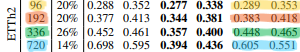

In [9]:
from IPython.display import Image
Image(filename=r"./Images/ETTh2.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 0.303977906703949 | 0.3672036826610565 |
| 192 | 0.3962155878543854 | 0.4267962872982025 |
| 336 | 0.4873389005661011| 0.4841303825378418 |
| 720 | 0.7422817349433899 | 0.6122018098831177 |

---
# Working on ETTm1 Dataset
---

## Trail 1: DLinear, Dataset:ETTm1,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [31]:
args.data_path = 'ETTm1.csv' # data file
args.data = 'ETTm1'  # data
args.pred_len = 96 # prediction sequence length

setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm1_96:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [32]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.3118564 (MSE)
    Speed: 0.2200 sec/iter 
    Left time: 2323.2004 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.2928477 (MSE)
    Speed: 0.2220 sec/iter 
    Left time: 2322.5070 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 300
--------------------------------------------------------------------------------
    Loss : 0.3284031 (MSE)
    Speed: 0.2350 sec/iter 
    Left time: 2435.1314 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 400
---------------------------------------------------------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=96, bias=True)
)

### Testing

In [33]:
exp.test(setting)
torch.cuda.empty_cache()

test 11425
mae:0.34351807832717896, mse:0.29958778619766235, rmse:0.5473461151123047, mape:2.008134126663208, mspe:301.59783935546875


---
## Trail 2: DLinear, Dataset:ETTm1 , Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary

In [34]:
args.pred_len = 192 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm1_192:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [35]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34033
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.3259308 (MSE)
    Speed: 0.2691 sec/iter 
    Left time: 2833.7622 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.3173579 (MSE)
    Speed: 0.2619 sec/iter 
    Left time: 2731.8374 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 300
--------------------------------------------------------------------------------
    Loss : 0.3610751 (MSE)
    Speed: 0.2660 sec/iter 
    Left time: 2747.9257 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 400
---------------------------------------------------------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=192, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=192, bias=True)
)

### Testing

In [36]:
exp.test(setting)
torch.cuda.empty_cache()

test 11329
mae:0.3638981282711029, mse:0.3339731991291046, rmse:0.5779041647911072, mape:2.0834333896636963, mspe:327.0799255371094


---
## Trail 3: DLinear, Dataset:ETTm1,  Metric: 336

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [37]:
args.pred_len = 336 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm1_336:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [38]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33889
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.3372852 (MSE)
    Speed: 0.4630 sec/iter 
    Left time: 4857.3039 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.3707517 (MSE)
    Speed: 0.4410 sec/iter 
    Left time: 4582.8233 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 300
--------------------------------------------------------------------------------
    Loss : 0.4191887 (MSE)
    Speed: 0.4380 sec/iter 
    Left time: 4507.2217 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 400
---------------------------------------------------------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=336, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=336, bias=True)
)

### Testing

In [39]:
exp.test(setting)
torch.cuda.empty_cache()

test 11185
mae:0.3842480182647705, mse:0.36858290433883667, rmse:0.6071102619171143, mape:2.1463780403137207, mspe:347.0400695800781


---
## Trail 4: DLinear, Dataset:ETTm1,  Metric: 720

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [40]:
args.pred_len = 720 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm1_720:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTm1', 'root_path': './Datasets/', 'data_path': 'ETTm1.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [41]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33505
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.3703685 (MSE)
    Speed: 0.1730 sec/iter 
    Left time: 1794.2555 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.4256070 (MSE)
    Speed: 0.1930 sec/iter 
    Left time: 1982.4209 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 300
--------------------------------------------------------------------------------
    Loss : 0.4599667 (MSE)
    Speed: 0.1839 sec/iter 
    Left time: 1870.8655 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 400
---------------------------------------------------------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=720, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=720, bias=True)
)

### Testing

In [42]:
exp.test(setting)
torch.cuda.empty_cache()

test 10801
mae:0.4168848395347595, mse:0.422527939081192, rmse:0.650021493434906, mape:2.250699043273926, mspe:385.1383972167969


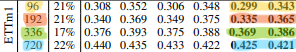

In [10]:
from IPython.display import Image
Image(filename=r"./Images/ETTm1.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 0.29958778619766235| 0.34351807832717896 |
| 192 | 0.3339731991291046 | 0.3638981282711029 |
| 336 | 0.36858290433883667 | 0.3842480182647705 |
| 720 | 0.422527939081192 | 0.4168848395347595 |

---
# Working on ETTm2 Dataset
---

## Trail 1: DLinear, Dataset:ETTm2,  Metric: 96
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [43]:
args.data_path = 'ETTm2.csv' # data file
args.data = 'ETTm2'  # data
args.pred_len = 96 # prediction sequence length

setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm2_96:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 96, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [44]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34129
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.1223088 (MSE)
    Speed: 0.1670 sec/iter 
    Left time: 1763.2831 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.1974948 (MSE)
    Speed: 0.1539 sec/iter 
    Left time: 1610.0571 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 300
--------------------------------------------------------------------------------
    Loss : 0.2206359 (MSE)
    Speed: 0.1030 sec/iter 
    Left time: 1067.6962 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 400
---------------------------------------------------------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=96, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=96, bias=True)
)

### Testing

In [45]:
exp.test(setting)
torch.cuda.empty_cache()

test 11425
mae:0.2625715732574463, mse:0.16786058247089386, rmse:0.4097079336643219, mape:1.0429506301879883, mspe:207.2598114013672


---
## Trail 2: DLinear,  Metric: 192
### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary

In [46]:
args.pred_len = 192 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm2_192:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 192, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [47]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 34033
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.2526741 (MSE)
    Speed: 0.2900 sec/iter 
    Left time: 3054.3689 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.3055680 (MSE)
    Speed: 0.1270 sec/iter 
    Left time: 1324.2915 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 300
--------------------------------------------------------------------------------
    Loss : 0.2648029 (MSE)
    Speed: 0.1069 sec/iter 
    Left time: 1104.8381 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 400
---------------------------------------------------------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=192, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=192, bias=True)
)

### Testing

In [48]:
exp.test(setting)
torch.cuda.empty_cache()

test 11329
mae:0.3251453638076782, mse:0.24425245821475983, rmse:0.494219034910202, mape:1.127162218093872, mspe:205.7145233154297


---
## Trail 3: DLinear, Dataset:ETTm2,  Metric: 336

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [49]:
args.pred_len = 336 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm2_336:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 336, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [50]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33889
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.2953589 (MSE)
    Speed: 0.6910 sec/iter 
    Left time: 7249.1858 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.3027904 (MSE)
    Speed: 0.6460 sec/iter 
    Left time: 6712.3573 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 300
--------------------------------------------------------------------------------
    Loss : 0.1751123 (MSE)
    Speed: 0.6230 sec/iter 
    Left time: 6411.6948 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 400
---------------------------------------------------------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=336, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=336, bias=True)
)

### Testing

In [51]:
exp.test(setting)
torch.cuda.empty_cache()

test 11185
mae:0.39706844091415405, mse:0.34370145201683044, rmse:0.5862605571746826, mape:1.1822333335876465, mspe:197.76922607421875


---
## Trail 4: DLinear, Dataset:ETTm2,  Metric: 720

### Set hyperparameters
Set some parameters (Args) for the our experiment like dictionary


In [52]:
args.pred_len = 720 # prediction sequence length
setting=f'DLinear_train_on_{args.data}_{args.pred_len}'
print(f"Hyperparameter Combination of {setting}:\n") 
print(args)

Hyperparameter Combination of DLinear_train_on_ETTm2_720:

{'model': 'DLinear', 'use_multi_gpu': False, 'use_gpu': True, 'learning_rate': 0.005, 'pred_len': 720, 'label_len': 48, 'use_amp': False, 'output_attention': False, 'features': 'M', 'train_only': True, 'checkpoints': './Checkpoints/DLinear_checkpoints', 'patience': 3, 'train_epochs': 10, 'data': 'ETTm2', 'root_path': './Datasets/', 'data_path': 'ETTm2.csv', 'target': 'OT', 'freq': 'h', 'seq_len': 336, 'enc_in': 7, 'dec_in': 7, 'c_out': 7, 'factor': 5, 'd_model': 512, 'n_heads': 8, 'e_layers': 2, 'd_layers': 1, 'd_ff': 2048, 'dropout': 0.05, 'attn': 'prob', 'embed': 'timeF', 'activation': 'gelu', 'distil': True, 'mix': True, 'padding': 0, 'batch_size': 32, 'loss': 'mse', 'lradj': 'type1', 'num_workers': 0, 'des': 'exp', 'gpu': 0, 'devices': '0,1,2,3'}


### Training

In [53]:
Exp = Exp_Main
exp = Exp(args)
exp.train(setting)

Use GPU: cuda:0
train 33505
                                   Training                               
Epoch: 1, Iters: 100
--------------------------------------------------------------------------------
    Loss : 0.7294015 (MSE)
    Speed: 0.6090 sec/iter 
    Left time: 6316.0883 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 200
--------------------------------------------------------------------------------
    Loss : 0.3703462 (MSE)
    Speed: 0.6151 sec/iter 
    Left time: 6317.2413 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 300
--------------------------------------------------------------------------------
    Loss : 0.4980204 (MSE)
    Speed: 0.6709 sec/iter 
    Left time: 6824.1978 sec
--------------------------------------------------------------------------------
Epoch: 1, Iters: 400
---------------------------------------------------------------------------

Model(
  (decompsition): series_decomp(
    (moving_avg): moving_avg(
      (avg): AvgPool1d(kernel_size=(25,), stride=(1,), padding=(0,))
    )
  )
  (Linear_Seasonal): Linear(in_features=336, out_features=720, bias=True)
  (Linear_Trend): Linear(in_features=336, out_features=720, bias=True)
)

### Testing

In [54]:
exp.test(setting)
torch.cuda.empty_cache()

test 10801
mae:0.45200106501579285, mse:0.44076594710350037, rmse:0.6639020442962646, mape:1.2872987985610962, mspe:199.3099365234375


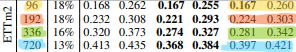

In [11]:
from IPython.display import Image
Image(filename=r"./Images/ETTm2.png")

#### **Experiment Results**:
Comaparing my results with the paper resulted highlited in the image above.

| Seq_len | MSE | MAE |
|---|---|---|
| 96 | 0.16786058247089386 | 0.2625715732574463 |
| 192 | 0.24425245821475983 | 0.3251453638076782 |
| 336 | 0.34370145201683044 |0.39706844091415405 |
| 720 | 0.44076594710350037 | 0.45200106501579285 |

---